In [1]:
from bioformers.datasets.ArrowDataset import ArrowDataset
from bioformers.datasets import dataset_utils
from bioformers.utilize.Bert import BertSeqClassification
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import os
import numpy
import warnings 

from transformers import BertModel, BertTokenizer
import re

from datasets import load_dataset
from datasets import Dataset
from datasets import load_from_disk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["MKL_THREADING_LAYER"] = "GNU"
os.environ["TOKENIZERS_PARALLELISM"] = "true"


num_cpu = 16
max_length = 512
lr = '1.81e-5'
num_labels = 1893
max_epch = 21
gpu = '3'
min_lr = float(5e-10)
max_lr = float(6e-08)

encoded_csv = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/encoded_labels_datasets/puffinCaller_encoded_dataset_withFunctional_individual_labels.csv"

saved_strat_train = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/tensor_datasets/puffinCaller_withFunctional_individual_labels_strat_train.pt"
saved_strat_val = "/mnt/storage/grid/home/eric/hmm2bert/data_prep/tensor_datasets/puffinCaller_withFunctional_individual_labels_strat_val.pt"

In [2]:
# load tokenizer and wandb logger

wandb_logger = WandbLogger(name=f"puffinCaller_classify_domain_1893_labels-{lr}", project="hmm_reBERT")

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
#model = BertModel.from_pretrained("Rostlab/prot_bert")



In [3]:
# load encoded label csv to huggingface dataset AND pandas dataframe
dataset = load_dataset('csv', data_files=encoded_csv)
df = pd.read_csv(encoded_csv)
dataset1 = dataset['train']
print(dataset1.column_names)
print("")
print(df.head())
print(df.tail())

Using custom data configuration default-b3c5fcf4d33a8721
Reusing dataset csv (/home/eric/.cache/huggingface/datasets/csv/default-b3c5fcf4d33a8721/0.0.0/2a88c45fed596f9421a2e7f74ab1a3cd012ef75210a5dc1950e8d60ca8d9c66c)


['sequence_ID', 'sequences', 'labels']

    sequence_ID                                          sequences  labels
0  LasI-sample1  V T E L K L A G T Q K N F E F E F N K M A A F ...     614
1  LasI-sample2  K M Q M V Q L G N E Y H L S R D I S Q I F N Q ...     614
2  LasI-sample3  E I R I T I T A K L L D F R K I G A E A S R L ...     614
3  LasI-sample4  H R A A A R P R L W S S E S Y D K E Q L H E L ...     614
4  LasI-sample5  Q A M I I C G G R E H S F Q S S C E S I L S M ...     614
       sequence_ID                                          sequences  labels
197582  1206469164  A V V G M A A R Y A D A E D P R A L W D H L M ...    1619
197583   930116041  A I I G M S G R F P G A R N V D E L W T I L R ...    1619
197584  4228394525  A I I G V A V R C G G A R N Q R E L W E L V R ...    1619
197585   525243953  A I I G M S G R F P G A R D V D E F W H V L L ...    1619
197586   165761117  A V I G M S G R F P Q A G N I A E M W K L V A ...    1619


In [4]:
# separate dataset into training and validation based on 'Labels' column in dataset

num_rows_list = list(range(len(dataset1)))
strat_train, strat_test = train_test_split(num_rows_list, stratify=dataset1['labels'], random_state=420)

print(len(strat_train))
print(len(strat_test))

148190
49397


In [5]:
#pass strat_train and strat_test into bioformers encoding function

strat_train_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_train]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_train_dataset1 = strat_train_dataset.remove_columns(['sequence_ID', '__index_level_0__'])

torch.save(strat_train_dataset1, saved_strat_train)

strat_test_dataset = dataset_utils.encode_dataset(
    subset=Dataset.from_pandas(df.iloc[strat_test]),
    tokenizer=tokenizer,
    key="sequences",
    include_labels=True,
    padding="max_length",
    max_length=512,
    truncation=True
)

strat_test_dataset1 = strat_test_dataset.remove_columns(['sequence_ID', '__index_level_0__'])

torch.save(strat_test_dataset1, saved_strat_val)

remove_columns_ is deprecated and will be removed in the next major version of datasets. Use the dataset.remove_columns method instead.


# ===========================================================

In [3]:
#load train and test tensors and instantiate pytorch lightning wrapper for the huggingface model with the base pretrained protbert model

encoded_train = torch.load(saved_strat_train)
encoded_test = torch.load(saved_strat_val)

bsc = BertSeqClassification(pretrained_dir="Rostlab/prot_bert", use_adafactor=True, num_labels=num_labels)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [4]:
# setup data collator, trainer, and dataloader for train and test dataset

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    max_epochs=max_epch,
    gpus=gpu,
    auto_lr_find=False,
    logger=wandb_logger
)

warnings.filterwarnings("ignore")

train_dl = DataLoader(encoded_train, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=True)
eval_dl = DataLoader(encoded_test, batch_size=4, num_workers=num_cpu, collate_fn=data_collator, shuffle=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [5]:
lr_finder = trainer.tuner.lr_find(bsc, train_dataloader=train_dl, min_lr=min_lr, max_lr=max_lr, num_training=100, mode='exponential', early_stop_threshold=4)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                          | Params
-------------------------------------------------------
0 | bert | BertForSequenceClassification | 421 M 
-------------------------------------------------------
421 M     Trainable params
0         Non-trainable params
421 M     Total params
1,687.486 Total estimated model params size (MB)


Restored states from the checkpoint file at /mnt/storage/grid/home/eric/hmm2bert/lr_find_temp_model.ckpt


In [6]:
lr_finder.results

{'lr': [5e-10,
  5.502418634425701e-10,
  5.772254111001296e-10,
  6.055322165695038e-10,
  6.352271716602777e-10,
  6.663783504394272e-10,
  6.99057165287409e-10,
  7.333385306071528e-10,
  7.693010345612492e-10,
  8.070271192310319e-10,
  8.466032696105575e-10,
  8.881202118687441e-10,
  9.316731213341714e-10,
  9.773618406793359e-10,
  1.02529110880454e-09,
  1.0755708009461158e-09,
  1.1283161805594177e-09,
  1.1836481635540167e-09,
  1.2416935954868347e-09,
  1.302585542348676e-09,
  1.3664635956107613e-09,
  1.4334741922305724e-09,
  1.5037709503505994e-09,
  1.5775150214595659e-09,
  1.6548754598234367e-09,
  1.736029610033115e-09,
  1.8211635135572553e-09,
  1.9104723352321984e-09,
  2.0041608106667245e-09,
  2.102443715587286e-09,
  2.2055463581996604e-09,
  2.3137050956957383e-09,
  2.4271678760895108e-09,
  2.5461948066243855e-09,
  2.671058750054874e-09,
  2.8020459501695917e-09,
  2.9394566879895516e-09,
  3.083605970146046e-09,
  3.234824251016192e-09,
  3.393458190271588

In [ ]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

# =====LR Finder=====


suggested lr: 1.1283161805594177e-09
min lr: 5e-10
max lr: 6e-08


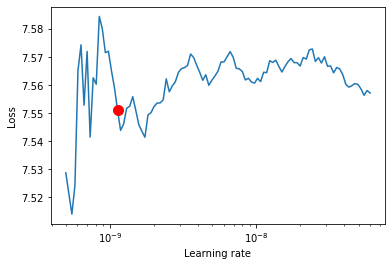

In [7]:
# 1.128e-09

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 3.2696303641434544e-09
min lr: 5e-10
max lr: 7e-08


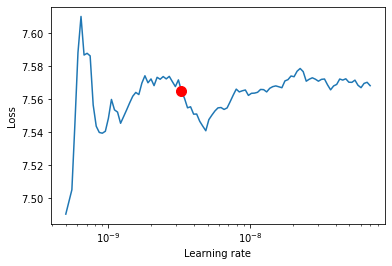

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 2.411277529216927e-09
min lr: 5e-10
max lr: 8e-08


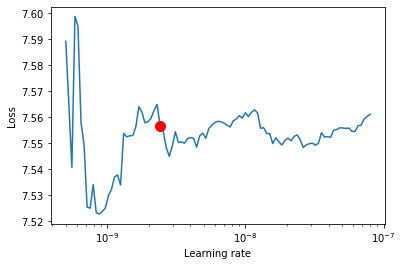

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 6.459970049778167e-09
min lr: 5e-10
max lr: 3e-07


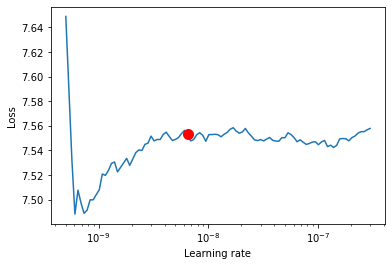

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 4.5777601938085014e-10
min lr: 1e-10
max lr: 3e-07


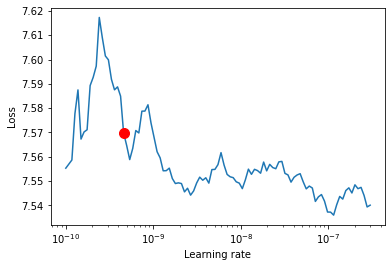

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 3.0259803296052406e-10
min lr: 1e-10
max lr: 5e-07


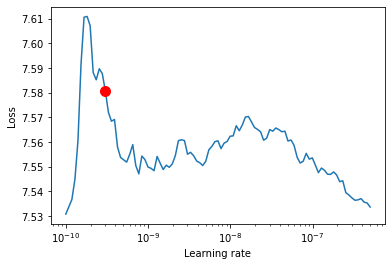

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 6.737112476804097e-10
min lr: 1e-10
max lr: 4e-07


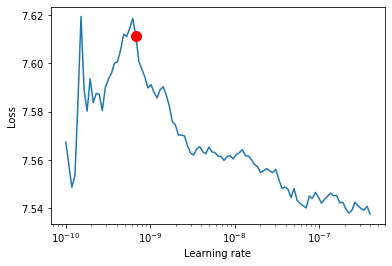

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 3.862100093708508e-09
min lr: 1e-10
max lr: 6e-07


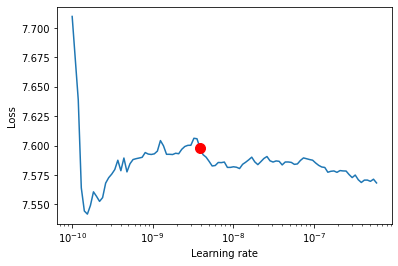

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 8.361313561376211e-08
min lr: 1e-10
max lr: 7e-07


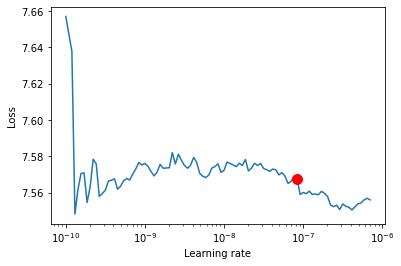

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 7.90152096970199e-10
min lr: 1e-10
max lr: 8e-07


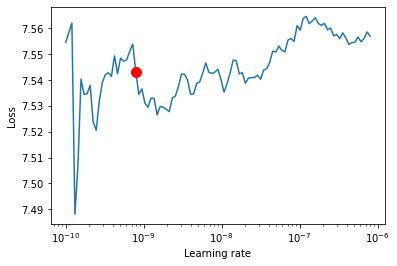

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 2.7224923997980443e-10
min lr: 1e-10
max lr: 9e-07


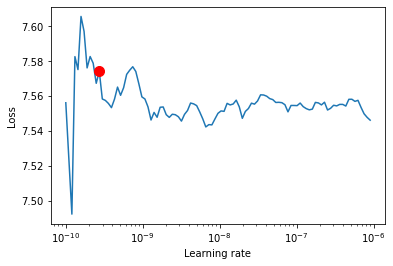

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 2.7542287033381663e-10
min lr: 1e-10
max lr: 1e-06


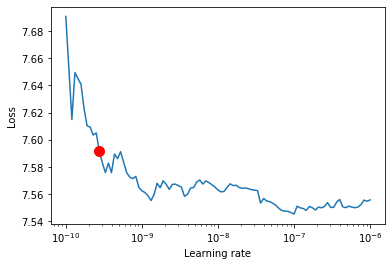

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 6.512884867768241e-10
min lr: 1e-10
max lr: 5e-07


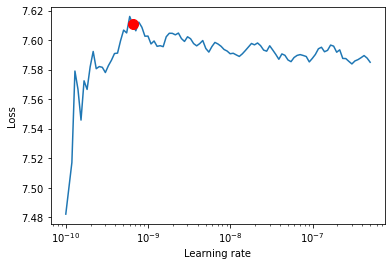

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 5.647226419959102e-10
min lr: 1e-10
max lr: 5e-06


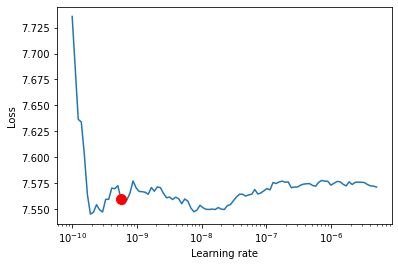

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 6.278498583506046e-10
min lr: 1e-10
max lr: 5e-05


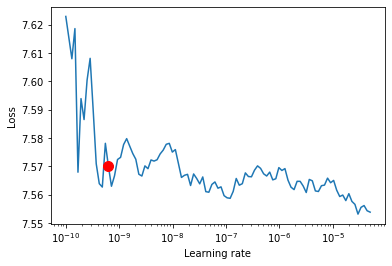

In [8]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 6.278498583506046e-10
min lr: 1e-10
max lr: 5e-05


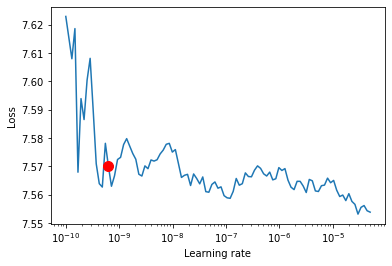

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 3.212822262467827e-29
min lr: 1e-30
max lr: 5e-17


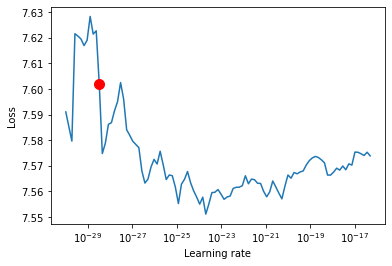

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 1.4813582531460434e-24
min lr: 1e-30
max lr: 5e-12


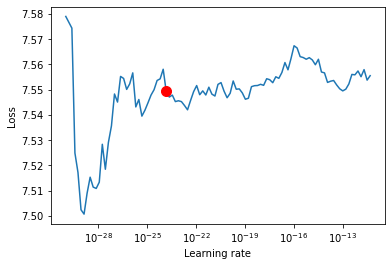

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 4.322267100567223e-24
min lr: 1e-30
max lr: 5e-07


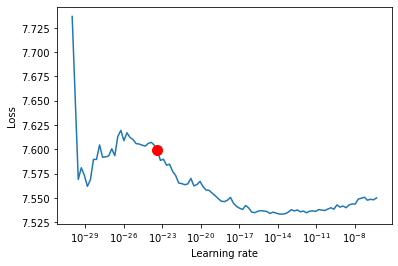

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 6.850331703687622e-17
min lr: 1e-20
max lr: 5e-07


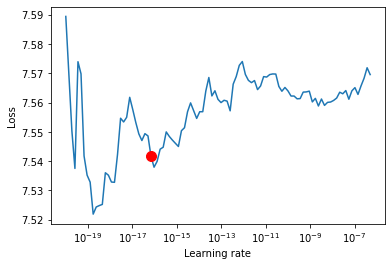

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))

suggested lr: 0.0006516606602815305
min lr: 1e-20
max lr: 0.005


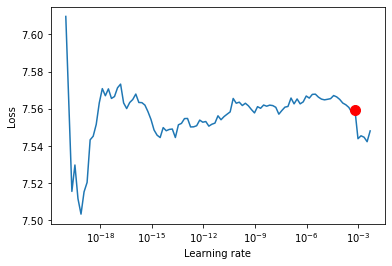

In [9]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 5.4561550137237676e-09
min lr: 1e-09
max lr: 0.005


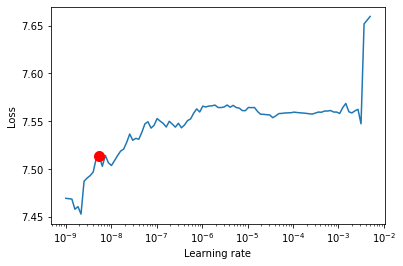

In [7]:
# lowest = forgot to enter

fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr))
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))


suggested lr: 2.0402857733683693e-07
min lr: 1e-09
max lr: 0.05


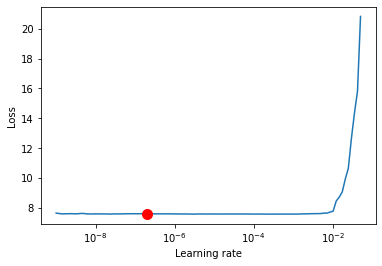

In [10]:
# lowest = forgot to enter
fig = lr_finder.plot(suggest=True)
fig.show()

new_lr = lr_finder.suggestion()
print("suggested lr: " + str(new_lr)) 
print("min lr: " + str(min_lr))
print("max lr: " + str(max_lr))